# Importing Libraries

In [4]:
#Libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

# Loading Dataset

In [6]:
#Dataset
df = pd.read_excel(r"E-com_Data.xlsx",header=0,index_col=None)

In [7]:
df_registered = df[df["CustomerID"].notnull()]
df_registered.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,NaN,NaN,NaN


# RFM Analysis

In [8]:
df_registered.drop(df_registered[df_registered['Cancelled_status']==1.0].index,inplace=True)
df_registered['Date'] = df_registered['Date of purchase'].apply(lambda x: x.date())
#Recency Dataframe
recency_df = df_registered.groupby(by='CustomerID',as_index=False)["Date"].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
SystemDate = dt.date(2018,1,1)
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (SystemDate - x).days)
recency_df.drop('LastPurchaseDate',axis = 1,inplace=True)
temp = df_registered.copy()
temp["InvoieNo"] = temp.InvoieNo.astype(object)
temp.drop_duplicates(['InvoieNo','CustomerID'],keep='first',inplace=True)
frequency_df = temp.groupby(by=['CustomerID'], as_index=False)['InvoieNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
monetary_df = df_registered.groupby(by = 'CustomerID',as_index=False).agg({'Price':'sum'})
monetary_df.columns = ['CustomerID','TotalPrice']
rfm_df = recency_df.merge(frequency_df,on='CustomerID').merge(monetary_df,on='CustomerID')
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head(5)

C:\Users\Hrithik shukla\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-5d897d4c0e76>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Recency,Frequency,TotalPrice
CustomerID,,,
2.0,16,7,553704.0
3.0,89,4,257404.0
4.0,31,1,176613.0
5.0,323,1,41976.0
6.0,49,7,166972.0


In [9]:
rfm_df.Recency.describe()

count    4324.000000
mean      105.755319
std       100.115549
min        13.000000
25%        31.000000
50%        64.000000
75%       155.250000
max       393.000000
Name: Recency, dtype: float64

C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



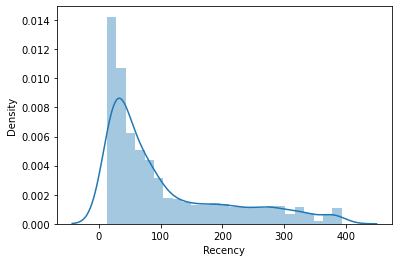

In [10]:
#Recency distrubution plot
X = rfm_df['Recency']
ax = sns.distplot(X)

count    4324.000000
mean        4.233349
std         7.583441
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: Frequency, dtype: float64


C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



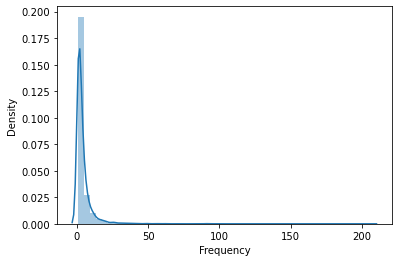

In [11]:
print(rfm_df.Frequency.describe())
Y = rfm_df['Frequency']
ay = sns.distplot(Y)

count    4.324000e+03
mean     2.339858e+05
std      8.636671e+05
min      3.880000e+02
25%      3.928800e+04
50%      8.614700e+04
75%      2.108338e+05
max      3.553619e+07
Name: TotalPrice, dtype: float64


C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



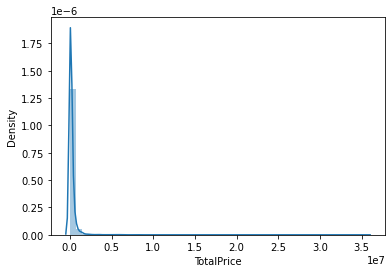

In [12]:
print(rfm_df.TotalPrice.describe())
Z = rfm_df['TotalPrice']
az = sns.distplot(Z)

In [13]:
rfm_df.TotalPrice.max()

35536194.0

In [14]:
#Split the four segments using quantiles 
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 31.0, 0.5: 64.0, 0.75: 155.25},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'TotalPrice': {0.25: 39288.0, 0.5: 86147.0, 0.75: 210833.75}}

In [15]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [16]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
rfm_df['R'] = rfm_df['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm_df['F'] = rfm_df['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm_df['M'] = rfm_df['TotalPrice'].apply(FnMScoring, args=('TotalPrice',quantiles,))
rfm_df.head()

,Recency,Frequency,TotalPrice,R,F,M
CustomerID,,,,,,
2.0,16,7,553704.0,1,1,1
3.0,89,4,257404.0,3,2,1
4.0,31,1,176613.0,1,4,2
5.0,323,1,41976.0,4,4,3
6.0,49,7,166972.0,2,1,2


In [17]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_df['RFMGroup'] = rfm_df.R.map(str) + rfm_df.F.map(str) + rfm_df.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm_df['RFMScore'] = rfm_df[['R', 'F', 'M']].sum(axis = 1)
rfm_df.head()

,Recency,Frequency,TotalPrice,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
2.0,16,7,553704.0,1,1,1,111,3
3.0,89,4,257404.0,3,2,1,321,6
4.0,31,1,176613.0,1,4,2,142,7
5.0,323,1,41976.0,4,4,3,443,11
6.0,49,7,166972.0,2,1,2,212,5


In [18]:
#Assign Loyalty Level to each customer
Loyalty_Level = [ 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm_df.RFMScore, q = 3, labels = Loyalty_Level)
rfm_df['RFM_Loyalty_Level'] = Score_cuts.values
rfm_df.reset_index().head()

,CustomerID,Recency,Frequency,TotalPrice,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,2.0,16,7,553704.0,1,1,1,111,3,Gold
1,3.0,89,4,257404.0,3,2,1,321,6,Gold
2,4.0,31,1,176613.0,1,4,2,142,7,Silver
3,5.0,323,1,41976.0,4,4,3,443,11,Bronze
4,6.0,49,7,166972.0,2,1,2,212,5,Gold


In [19]:
rfm_df.RFM_Loyalty_Level.value_counts()

Gold      1622
Bronze    1412
Silver    1290
Name: RFM_Loyalty_Level, dtype: int64

In [20]:
"""


#Recency Vs Frequency
graph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

"""

'\n\n\n#Recency Vs Frequency\ngraph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")\n\nplot_data = [\n    gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'Frequency\'],\n        mode=\'markers\',\n        name=\'Bronze\',\n        marker= dict(size= 7,\n            line= dict(width=1),\n            color= \'blue\',\n            opacity= 0.8\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'Frequency\'],\n        mode=\'markers\',\n        name=\'Silver\',\n        marker= dict(size= 9,\n            line= dict(width=1),\n            color= \'green\',\n            opacity= 0.5\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'Frequen

In [21]:
"""
#Frequency Vs Monetary
graph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['TotalPrice'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['TotalPrice'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['TotalPrice'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['TotalPrice'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "TotalPrice"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)
"""

'\n#Frequency Vs Monetary\ngraph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")\n\nplot_data = [\n    gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'Frequency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'TotalPrice\'],\n        mode=\'markers\',\n        name=\'Bronze\',\n        marker= dict(size= 7,\n            line= dict(width=1),\n            color= \'blue\',\n            opacity= 0.8\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'Frequency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'TotalPrice\'],\n        mode=\'markers\',\n        name=\'Silver\',\n        marker= dict(size= 9,\n            line= dict(width=1),\n            color= \'green\',\n            opacity= 0.5\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'Frequency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'To

In [22]:
"""
#Recency Vs Monetary
graph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['TotalPrice'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['TotalPrice'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['TotalPrice'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['TotalPrice'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "TotalPrice"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)"""

'\n#Recency Vs Monetary\ngraph = rfm_df.query("TotalPrice < 35536194.0 and Frequency < 206")\n\nplot_data = [\n    gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Bronze\'")[\'TotalPrice\'],\n        mode=\'markers\',\n        name=\'Bronze\',\n        marker= dict(size= 7,\n            line= dict(width=1),\n            color= \'blue\',\n            opacity= 0.8\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Silver\'")[\'TotalPrice\'],\n        mode=\'markers\',\n        name=\'Silver\',\n        marker= dict(size= 9,\n            line= dict(width=1),\n            color= \'green\',\n            opacity= 0.5\n           )\n    ),\n        gobj.Scatter(\n        x=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'Recency\'],\n        y=graph.query("RFM_Loyalty_Level == \'Gold\'")[\'TotalPrice

# K mean Clustering

In [23]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_df['Recency'] = [handle_neg_n_zero(x) for x in rfm_df.Recency]
rfm_df['TotalPrice'] = [handle_neg_n_zero(x) for x in rfm_df.TotalPrice]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_df[['Recency', 'Frequency', 'TotalPrice']].apply(np.log, axis = 1).round(3)

C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



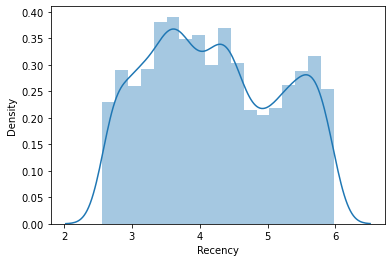

In [24]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



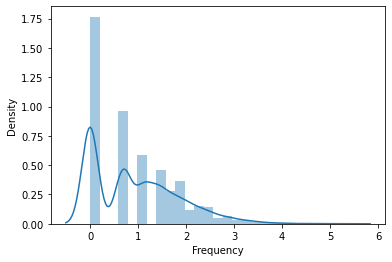

In [25]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data['Frequency']
ax = sns.distplot(Frequency_Plot)

In [26]:
Log_Tfd_Data.Frequency.max()

5.328

C:\Users\Hrithik shukla\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



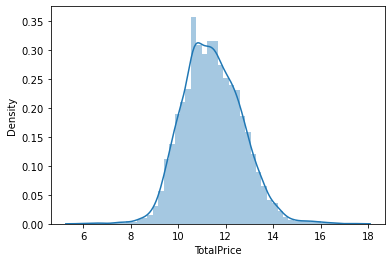

In [27]:

#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data['TotalPrice']
ax = sns.distplot(Monetary_Plot)

In [28]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_df.index, columns = Log_Tfd_Data.columns)

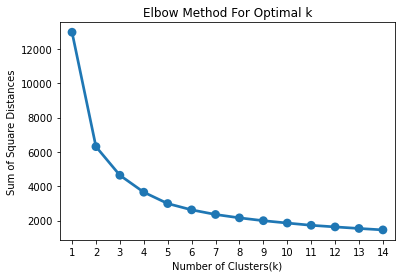

In [29]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
# Silhouette Score
from sklearn.metrics import silhouette_score
for num in range(2,16):
    clusters = KMeans(n_clusters=num,random_state=0)
    labels = clusters.fit_predict(Scaled_Data)
    
    sil_avg = silhouette_score(Scaled_Data, labels)
    print('For',num,'The Silhouette Score is =',sil_avg)

For 2 The Silhouette Score is = 0.42676252730043823
For 3 The Silhouette Score is = 0.34036027305247984
For 4 The Silhouette Score is = 0.3320595638918118
For 5 The Silhouette Score is = 0.3394413333564374
For 6 The Silhouette Score is = 0.32547111039932086
For 7 The Silhouette Score is = 0.31791701770772446
For 8 The Silhouette Score is = 0.2924880031535917
For 9 The Silhouette Score is = 0.2825073639754638
For 10 The Silhouette Score is = 0.2877269685418858
For 11 The Silhouette Score is = 0.28862478666143443
For 12 The Silhouette Score is = 0.287594007715833
For 13 The Silhouette Score is = 0.2813041792698712
For 14 The Silhouette Score is = 0.286980318539729
For 15 The Silhouette Score is = 0.28602148702889685


In [31]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset

rfm_df['Cluster'] = KMean_clust.labels_
rfm_df.head()

,Recency,Frequency,TotalPrice,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
2.0,16,7,553704.0,1,1,1,111,3,Gold,0
3.0,89,4,257404.0,3,2,1,321,6,Gold,0
4.0,31,1,176613.0,1,4,2,142,7,Silver,1
5.0,323,1,41976.0,4,4,3,443,11,Bronze,2
6.0,49,7,166972.0,2,1,2,212,5,Gold,0


<Figure size 504x504 with 0 Axes>

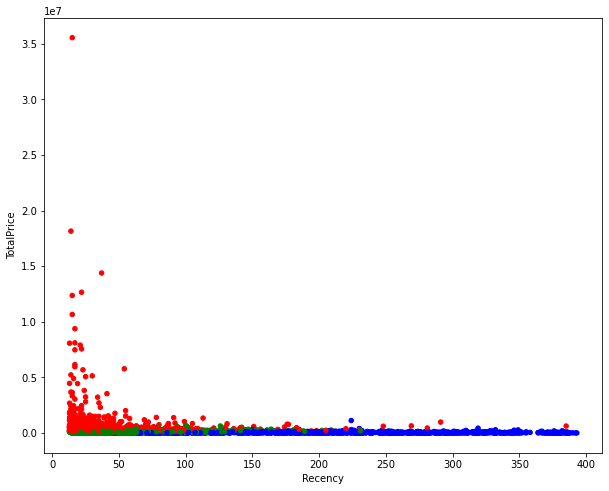

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue",'orange']
rfm_df['Color'] = rfm_df['Cluster'].map(lambda p: Colors[p])
ax = rfm_df.plot(    
    kind="scatter", 
    x="Recency", y="TotalPrice",
    figsize=(10,8),
    c = rfm_df['Color'])

In [33]:
rfm_df["Cluster"] = rfm_df.Cluster.map({0:"Gold",1:"Silver",2:"Bronze"})


In [34]:
rfm_df.Cluster.value_counts()

Silver    1702
Bronze    1389
Gold      1233
Name: Cluster, dtype: int64

In [35]:
rfm_df.head()

,Recency,Frequency,TotalPrice,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
2.0,16,7,553704.0,1,1,1,111,3,Gold,Gold,red
3.0,89,4,257404.0,3,2,1,321,6,Gold,Gold,red
4.0,31,1,176613.0,1,4,2,142,7,Silver,Silver,green
5.0,323,1,41976.0,4,4,3,443,11,Bronze,Bronze,blue
6.0,49,7,166972.0,2,1,2,212,5,Gold,Gold,red
